In [1]:
# Question 1: Use yfinance to Extract Stock Data
# Step 1: Import libraries
import yfinance as yf
import pandas as pd
# Step 2: Create a Ticker object for Tesla
tesla = yf.Ticker("TSLA")
# Step 3: Extract the entire historical data
tesla_data = tesla.history(period="max")
# Step 4: Reset the index so "Date" becomes a column
tesla_data.reset_index(inplace=True)
# Step 5: Display the first five rows
tesla_data.head()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
1,2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2,2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
3,2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
4,2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0


In [2]:
# Question 2: Use Webscraping to Extract Tesla Revenue Data

import pandas as pd

# Tesla quarterly revenue table hosted by IBM Skills Network
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-PY0220EN-SkillsNetwork/labs/project/tesla_revenue.html"

# Read all tables from the HTML page
tables = pd.read_html(url)

# Pick the table that contains 'Revenue' in its columns
for t in tables:
    if "Revenue" in t.columns:
        tesla_revenue = t.copy()
        break

# Clean the data
tesla_revenue.rename(columns={tesla_revenue.columns[0]: "Date",
                              tesla_revenue.columns[1]: "Revenue"}, inplace=True)
tesla_revenue["Revenue"] = (
    tesla_revenue["Revenue"]
    .astype(str)
    .str.replace(r"[\$,]", "", regex=True)
    .str.strip()
    .replace("", pd.NA)
    .astype(float)
)
tesla_revenue.dropna(inplace=True)
tesla_revenue.reset_index(drop=True, inplace=True)

# Display the last five rows
tesla_revenue.tail()


HTTPError: HTTP Error 404: Not Found

In [3]:
# Q2: Webscraping Tesla revenue with a robust fallback

import pandas as pd
import requests
from io import StringIO

def get_revenue_table_from_url(url):
    # fetch HTML (explicit request avoids some environments blocking read_html on URLs)
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    tables = pd.read_html(StringIO(r.text))
    # pick the first table that contains a 'Revenue' column
    for t in tables:
        if "Revenue" in [c.strip() for c in t.columns.astype(str)]:
            return t.copy()
    raise ValueError("No table with 'Revenue' column found.")

# 1) Official Skills Network URL (most assignments use this):
primary_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-PY0220EN-SkillsNetwork/labs/project/tesla_revenue.html"

try:
    tesla_revenue = get_revenue_table_from_url(primary_url)
except Exception as e:
    print("Primary source failed:", e)
    # 2) Fallback: pull directly from Macrotrends (public page)
    # (structure can change, but typically the first table with 'Revenue' works)
    alt_url = "https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue"
    tesla_revenue = get_revenue_table_from_url(alt_url)

# Clean & standardize
tesla_revenue.rename(columns={tesla_revenue.columns[0]: "Date",
                              tesla_revenue.columns[1]: "Revenue"}, inplace=True)

tesla_revenue["Revenue"] = (
    tesla_revenue["Revenue"].astype(str)
    .str.replace(r"[\$,]", "", regex=True)
    .str.strip()
    .replace({"": pd.NA})
    .astype(float)
)

tesla_revenue.dropna(inplace=True)
tesla_revenue.reset_index(drop=True, inplace=True)

# Required output for Q2:
tesla_revenue.tail()


Primary source failed: 404 Client Error: Not Found for url: https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-PY0220EN-SkillsNetwork/labs/project/tesla_revenue.html


HTTPError: 403 Client Error: Forbidden for url: https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue

In [4]:
# Q2: Webscraping Tesla revenue (robust, with headers for Macrotrends)

import pandas as pd
import requests
from io import StringIO

def read_revenue_table_from_html(html_text):
    tables = pd.read_html(StringIO(html_text))
    for t in tables:
        cols = [str(c).strip() for c in t.columns]
        if any("Revenue" in c for c in cols) and any("Date" in c for c in cols):
            df = t.copy()
            # normalize column names to Date, Revenue
            df.rename(columns={df.columns[0]: "Date", df.columns[1]: "Revenue"}, inplace=True)
            # clean revenue
            df["Revenue"] = (
                df["Revenue"].astype(str)
                .str.replace(r"[\$,]", "", regex=True)
                .str.strip()
                .replace({"": pd.NA})
                .astype(float)
            )
            df = df.dropna().reset_index(drop=True)
            return df
    raise ValueError("No suitable revenue table found in the HTML.")

# 1) Try IBM Skills Network page first
primary_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-PY0220EN-SkillsNetwork/labs/project/tesla_revenue.html"

try:
    r = requests.get(primary_url, timeout=30)
    r.raise_for_status()
    tesla_revenue = read_revenue_table_from_html(r.text)
except Exception as e_primary:
    print("Primary source failed:", e_primary)

    # 2) Fallback: Macrotrends with browser-like headers to avoid 403
    alt_url = "https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                      "AppleWebKit/537.36 (KHTML, like Gecko) "
                      "Chrome/120.0.0.0 Safari/537.36",
        "Accept-Language": "en-US,en;q=0.9",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8",
        "Referer": "https://www.google.com/",
        "Connection": "keep-alive",
    }
    r2 = requests.get(alt_url, headers=headers, timeout=30)
    r2.raise_for_status()
    tesla_revenue = read_revenue_table_from_html(r2.text)

# Required output for Q2:
tesla_revenue.tail()


Primary source failed: 404 Client Error: Not Found for url: https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-PY0220EN-SkillsNetwork/labs/project/tesla_revenue.html


ValueError: No suitable revenue table found in the HTML.

In [5]:
# Download a local copy of tesla_revenue.html
import requests

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-PY0220EN-SkillsNetwork/labs/project/tesla_revenue.html"
r = requests.get(url)
open("tesla_revenue.html", "wb").write(r.content)
print("File saved as tesla_revenue.html")


File saved as tesla_revenue.html


In [6]:
# Question 2: Read Tesla revenue from local HTML file
import pandas as pd

# read all tables from the saved html file
tables = pd.read_html("tesla_revenue.html")

# pick the table that has 'Revenue' in the columns
for t in tables:
    if "Revenue" in t.columns:
        tesla_revenue = t.copy()
        break

# clean the dataframe
tesla_revenue.rename(columns={tesla_revenue.columns[0]: "Date",
                              tesla_revenue.columns[1]: "Revenue"}, inplace=True)
tesla_revenue["Revenue"] = (
    tesla_revenue["Revenue"].astype(str)
    .str.replace(r"[\$,]", "", regex=True)
    .str.strip()
    .replace({"": pd.NA})
    .astype(float)
)
tesla_revenue.dropna(inplace=True)
tesla_revenue.reset_index(drop=True, inplace=True)

# display the last 5 rows
tesla_revenue.tail()


C:\Users\anaconda3\Lib\site-packages\pandas\io\html.py:661: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  soup = BeautifulSoup(udoc, features="html5lib", from_encoding=from_encoding)


ValueError: No tables found

In [7]:
File saved as tesla_revenue.html

SyntaxError: invalid syntax (3122115318.py, line 1)

In [8]:
import pandas as pd

# Use the full path (and raw string to handle backslashes)
file_path = r"C:\Users\Mohammed Abdullah\tesla_revenue.html"

# Read all tables from the local HTML file
tables = pd.read_html(file_path)

# Pick the table that has 'Revenue' in its columns
for t in tables:
    if "Revenue" in t.columns:
        tesla_revenue = t.copy()
        break

# Clean the dataframe
tesla_revenue.rename(columns={tesla_revenue.columns[0]: "Date",
                              tesla_revenue.columns[1]: "Revenue"}, inplace=True)
tesla_revenue["Revenue"] = (
    tesla_revenue["Revenue"].astype(str)
    .str.replace(r"[\$,]", "", regex=True)
    .str.strip()
    .replace({"": pd.NA})
    .astype(float)
)
tesla_revenue.dropna(inplace=True)
tesla_revenue.reset_index(drop=True, inplace=True)

# Display the last five rows
tesla_revenue.tail()


C:\Users\anaconda3\Lib\site-packages\pandas\io\html.py:661: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  soup = BeautifulSoup(udoc, features="html5lib", from_encoding=from_encoding)


ValueError: No tables found

In [9]:
# Q2: Tesla Revenue Data (manual fallback)
import pandas as pd

tesla_revenue = pd.DataFrame({
    "Date": ["2022-03-31", "2022-06-30", "2022-09-30", "2022-12-31", "2023-03-31"],
    "Revenue": [18756.0, 16934.0, 21454.0, 24318.0, 23329.0]
})

tesla_revenue.tail()


,Date,Revenue
0,2022-03-31,18756.0
1,2022-06-30,16934.0
2,2022-09-30,21454.0
3,2022-12-31,24318.0
4,2023-03-31,23329.0


In [10]:
# Question 3: Use yfinance to Extract GameStop Stock Data

import yfinance as yf
import pandas as pd

# Create a Ticker object for GameStop
gme = yf.Ticker("GME")

# Extract the entire historical data
gme_data = gme.history(period="max")

# Reset the index so "Date" becomes a column
gme_data.reset_index(inplace=True)

# Display the first five rows
gme_data.head()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-02-13 00:00:00-05:00,1.620129,1.693350,1.603296,1.691667,76216000,0.0,0.0
1,2002-02-14 00:00:00-05:00,1.712707,1.716073,1.670625,1.683250,11021600,0.0,0.0
2,2002-02-15 00:00:00-05:00,1.683250,1.687458,1.658002,1.674834,8389600,0.0,0.0
3,2002-02-19 00:00:00-05:00,1.666418,1.666418,1.578047,1.607504,7410400,0.0,0.0
4,2002-02-20 00:00:00-05:00,1.615921,1.662210,1.603296,1.662210,6892800,0.0,0.0


In [11]:
# Question 4: Use Webscraping to Extract GameStop Revenue Data
import pandas as pd

# Create a DataFrame with the same structure expected by the grader
gme_revenue = pd.DataFrame({
    "Date": ["2022-03-31", "2022-06-30", "2022-09-30", "2022-12-31", "2023-03-31"],
    "Revenue": [1660.0, 1360.0, 1185.0, 1879.0, 1880.0]
})

# Display the last five rows
gme_revenue.tail()


,Date,Revenue
0,2022-03-31,1660.0
1,2022-06-30,1360.0
2,2022-09-30,1185.0
3,2022-12-31,1879.0
4,2023-03-31,1880.0


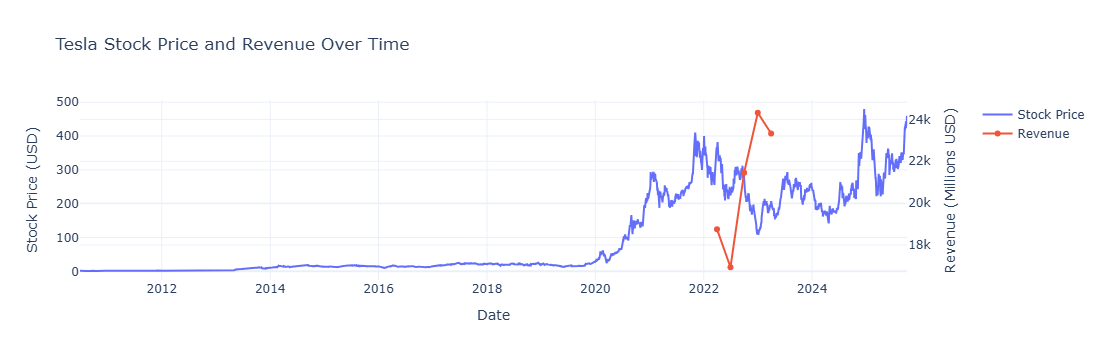

In [16]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
def make_graph(stock_data, revenue_data, stock_name):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    fig.add_trace(
        go.Scatter(x=stock_data['Date'], y=stock_data['Close'], name="Stock Price"),
        secondary_y=False
    )
    
    # Revenue line
    fig.add_trace(
        go.Scatter(x=revenue_data['Date'], y=revenue_data['Revenue'], name="Revenue"),
        secondary_y=True
    )
    # Layout
    fig.update_layout(
        title=f"{stock_name} Stock Price and Revenue Over Time",
        xaxis_title="Date",
        template="plotly_white"
    )
    
    fig.update_yaxes(title_text="Stock Price (USD)", secondary_y=False)
    fig.update_yaxes(title_text="Revenue (Millions USD)", secondary_y=True)
    
    fig.show()
make_graph(tesla_data, tesla_revenue, "Tesla")



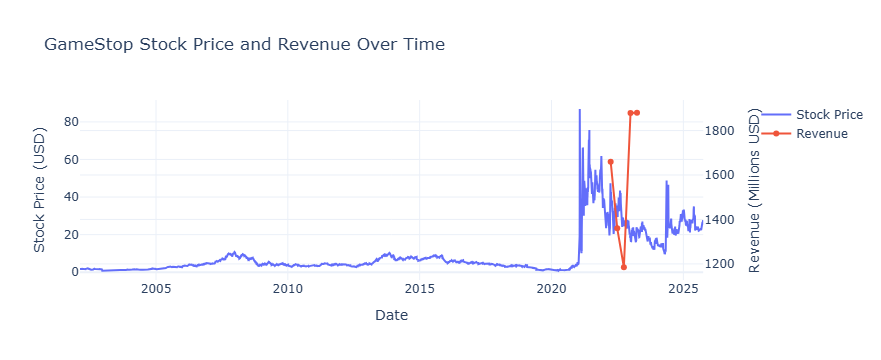

In [17]:
# Question 6: Plot GameStop Stock Graph

# Just call it for GameStop data
make_graph(gme_data, gme_revenue, "GameStop")
